In [1]:
import numpy as np
import time
import math
from scipy import stats
import matplotlib.pyplot as plt
% matplotlib inline

### Game Graph Class

In [2]:
class node:
    '''A simple node in a binary tree'''
    def __init__(self, value=None, left=None, right=None, parent=None):
        self.value = value
        self.left = left
        self.right = right
        self.parent = parent
        
def make_children(source):
    '''Creates and returns left and right children for source node'''
    left = node(parent=source)
    right = node(parent=source)
    source.left = left
    source.right = right
    return left, right

def make_tree(n):
    '''Builds a tree of depth n'''
    source = node()
    tree = [[] for i in range(n+1)]  # i is depth
    tree[0].append(source)
    # Add children depth-by-depth
    for i in range(n):
        for j in range(pow(2, i)):
            tree[i+1]+=make_children(tree[i][j])
    # Compute random leaf values
    for leaf in tree[-1]:
        leaf.value = 2*np.random.random()-1
#     for j in range(pow(2, n)):
#         tree[n][j].value = np.random.random()
    return tree

def make_tree_fast(n):
    '''Builds a tree of depth n more efficiently'''
    # Create the root node
    tree = [[node()]]  # No parent
    
    # Create the intermediate levels of the tree
    nodes = [range(2**depth) for depth in range(1, n)]   
    tree += [[node() for v in level] for level in nodes]
    
    # Create the leaves
    tree += [[node() for v in range(2**n)]]  # No children

    # TODO: NEED TO CONNECT CHILDREN AND PARENTS OR CHANGE DFS ALGORITHM
    
    # Compute random leaf values
    for leaf in tree[-1]:
        leaf.value = 2*np.random.random()-1
    return tree

def print_tree(tree):
    '''Prints value of all nodes in tree by depth'''
    for depth, level in enumerate(tree):
        vals = [v.value for v in level]
        print('Depth {} has {} nodes: {}'.format(depth, len(vals), vals))
    print('')

def get_value(tree):    
    '''Returns value of root node'''
    return tree[0][0].value
    
def print_value(tree):
    '''Prints value of root node'''
    print('The value to the first player, Paul, is: {}'.format(get_value(tree)))

In [45]:
n=4

# Create the root node
tree = [[node()]]  # No parent

# Create the intermediate levels of the tree
nodes = [range(2**depth) for depth in range(1, n)]   
tree += [[node() for v in level] for level in nodes]

# Create the leaves
tree += [[node() for v in range(2**n)]]  # No children

print_tree(tree)

Depth 0 has 1 nodes: [None]
Depth 1 has 2 nodes: [None, None]
Depth 2 has 4 nodes: [None, None, None, None]
Depth 3 has 8 nodes: [None, None, None, None, None, None, None, None]
Depth 4 has 16 nodes: [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]



### Value Calculation

In [3]:
# Example tree:
tree4 = make_tree_fast(4)
# for v in tree4[-1]:
#     v.value=np.random.random()

print_tree(tree4)
BOOM

def DFS_visit(node, Paul=True):
    '''Computes the value for each node'''
    if not node.value:
        DFS_visit(node.left, Paul=not Paul)
        DFS_visit(node.right, Paul=not Paul)
        if node.left.value:
            if node.right.value:
                if Paul:  # Maximizing player
                    node.value = max(node.left.value, node.right.value)
                else:  # Minimizing player
                    node.value = min(node.left.value, node.right.value)   
                                        
def DFS_visit_fast(node, alpha, beta, Paul=True):
    '''Computes the values for nodes with alpha-beta pruning to limit search'''
    if not node.value:
        DFS_visit_fast(node.left, alpha, beta, Paul=not Paul)
        DFS_visit_fast(node.right, alpha, beta, Paul=not Paul)
        if node.left.value:
            if node.right.value:
                if Paul:  # Maximizing player
                    node.value = max(node.left.value, node.right.value)
                    alpha = max(alpha, node.value)
                    if beta <= alpha:
                        print('I am breaking! beta cutoff')
                        return
                else:  # Minimizing player
                    node.value = min(node.left.value, node.right.value)       
                    beta = min(beta, node.value)
                    if beta <= alpha:
                        print('I am breaking! alpha cutoff')
                        return
                    
# Example calculation:                    
DFS_visit_fast(tree4[0][0])
print_tree(tree4)
print_value(tree4)

# tree4copy = make_tree_fast(4)
# DFS_visit_fast(tree4copy[0][0], -math.inf, math.inf)
# print_tree(tree4copy)
# print_value(tree4copy)

Depth 0 has 1 nodes: [-0.412900986919599]
Depth 1 has 2 nodes: [-0.412900986919599, -0.504746577109904]
Depth 2 has 4 nodes: [-0.2897336418756442, -0.412900986919599, -0.14005659326695796, -0.504746577109904]
Depth 3 has 8 nodes: [-0.48450117669145176, -0.2897336418756442, -0.9668639702019144, -0.412900986919599, -0.14005659326695796, -0.8833904810056747, -0.7836995970053349, -0.504746577109904]
Depth 4 has 16 nodes: [-0.48450117669145176, 0.3618117734629658, 0.6289764339981287, -0.2897336418756442, -0.9668639702019144, 0.4979055415172948, -0.15981864366742293, -0.412900986919599, 0.5960018001012477, -0.14005659326695796, 0.2181393333814201, -0.8833904810056747, 0.27457565675491535, -0.7836995970053349, -0.504746577109904, 0.6522028582250956]

The value to the first player, Paul, is: -0.412900986919599


### Simulations
#### 1 Advantage to playing last? Test the effect of parity of tree depth.

In [4]:
# Create the lists of even and odd depths to use
ks = np.random.randint(5, 10, 100)
even_numbers = 2*ks
plus_or_minus = np.random.choice((1, -1))
odd_numbers = even_numbers + plus_or_minus

# Build the trees
t0 = time.time()
even_trees_copy = [make_tree(n) for n in even_numbers]
t1 = time.time()
print('Time to make all even trees without speed-up: {} sec'.format(t1 - t0))

t0 = time.time()
even_trees = [make_tree_fast(n) for n in even_numbers]
t1 = time.time()
print('Time to make all even trees with speed-up: {} sec'.format(t1 - t0))

odd_trees = [make_tree_fast(n) for n in odd_numbers]

# Compute values for the trees
even_trees_copy2 = [make_tree_fast(n) for n in even_numbers]
t0 = time.time()
for tree in even_trees_copy2:
    DFS_visit(tree[0][0])
t1 = time.time()
print('Time to compute values for all even trees without alpha-beta pruning: {} sec'.format(t1 - t0))

t0 = time.time()
for tree in even_trees:
    DFS_visit_fast(tree[0][0], -math.inf, math.inf)
t1 = time.time()
print('Time to compute values for all even trees with alpha-beta pruning: {} sec'.format(t1 - t0))

for tree in odd_trees:
    DFS_visit_fast(tree[0][0])    

Time to make all even trees: 31.117762327194214 sec
Time to compute values for all even trees: 6.76198410987854 sec
Time to compute values for all even trees with alpha-beta pruning: 8.88763689994812 sec


In [5]:
odd_values = [get_value(tree) for tree in odd_trees]
even_values = [get_value(tree) for tree in even_trees]
print('Mean value to Paul for odd trees: {}\nMean value to Paul for even trees: {}'.format(np.mean(odd_values), np.mean(even_values)))
stats.ttest_ind(odd_values, even_values, equal_var=False)
# No advantage to playing last if pvalue > 0.05
# Advantage to playing last if pvalue < 0.05

Mean value to Paul for odd trees: 0.25539476323850235
Mean value to Paul for even trees: -0.2166966432024006


Ttest_indResult(statistic=51.161249356106651, pvalue=4.6874036090387695e-105)

#### 2. Advantage to playing first? Run t-test on all results against 0.

In [6]:
values = odd_values + even_values
print('Mean value to Paul for odd and even trees: {}'.format(np.mean(values)))
stats.ttest_1samp(values, popmean=0)
# No advantage to playing first if pvalue > 0.05
# Advantage to playing first if pvalue < 0.05

Mean value to Paul for odd and even trees: 0.019349060018050875


Ttest_1sampResult(statistic=1.1149508809209303, pvalue=0.26621614230056484)

#### 3. Variance and 4. Plot distribution of results

With depth of 15, the average value for the first player, Paul, is: 0.24
With depth of 15, the standard deviation for the value for the first player, Paul, is: 0.03


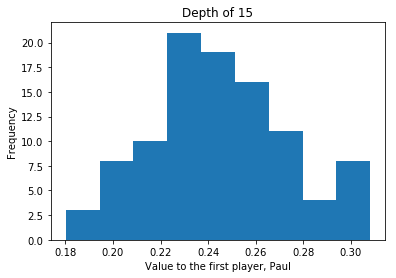

With depth of 16, the average value for the first player, Paul, is: -0.23
With depth of 16, the standard deviation for the value for the first player, Paul, is: 0.02


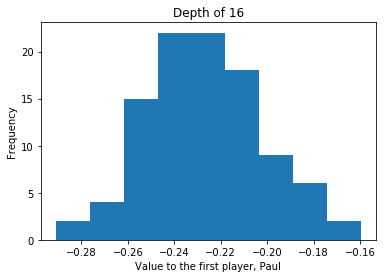

In [7]:
ns = [15]*100
trees15 = [make_tree_fast(n) for n in ns]
for tree in trees15:
    DFS_visit_fast(tree[0][0])

values = [get_value(tree) for tree in trees15]
print('With depth of %d, the average value for the first player, Paul, is: %.2f' % (ns[0], np.mean(values)))
print('With depth of %d, the standard deviation for the value for the first player, Paul, is: %.2f' % (ns[0], np.std(values)))

n, bins, patches = plt.hist(values, bins=9)
plt.xlabel('Value to the first player, Paul')
plt.ylabel('Frequency')
plt.title('Depth of %d' % ns[0])
plt.show()

ns = [16]*100
trees16 = [make_tree_fast(n) for n in ns]
for tree in trees16:
    DFS_visit_fast(tree[0][0])

values = [get_value(tree) for tree in trees16]
print('With depth of %d, the average value for the first player, Paul, is: %.2f' % (ns[0], np.mean(values)))
print('With depth of %d, the standard deviation for the value for the first player, Paul, is: %.2f' % (ns[0], np.std(values)))

n, bins, patches = plt.hist(values, bins=9)
plt.xlabel('Value to the first player, Paul')
plt.ylabel('Frequency')
plt.title('Depth of %d' % ns[0])
plt.show()

#### 5. Determine $\lim_{n\rightarrow \infty}Value[s]$

In [8]:
# ## Caution: this takes long unless you add alpha-beta pruning!
# ### It likely kills the kernel
# large_tree = make_tree_fast(40)
# time0 = time.time()
# DFS_visit_fast(large_tree[0][0])
# time1 = time.time()
# print("Large tree value computation took %.3f seconds."(time1 - time0))